<p style="font-size:16px;">
    This is a testing notebook for trying the models before commiting to properly training them. Not only that, it allows for easier and more interactive visualizations once we have the trained weights.
</p>
<p style="font-size:16px;">
    It is divided into 3 main parts:
    <ul style="font-size:16px;">
        <li><b>Data Preparation:</b> Loading data, visualizing it to better understand the inputs and preparing it with the appropriate shape and data structure for the models</li>
        <li><b>Building Models:</b> Defining the models and testing small training instances to check they're working</li>
        <li><b>Visualizations:</b> Implementing various types of visualizations given the trained models to benefit from their insights</li>
    </ul>
</p>

# Data Preparation

<ul style="font-size:16px;">
    <li>Reading preprocessed data in an interleaved manner to extract data from both dancers separately</li>
    <li>Creating adjacencies by:
        <ol>
            <li>Initializing default skeleton for 29 joints</li>
            <li>Repeating the process for the second dancer</li>
            <li>Connecting every joint of a dancer to all joints on the other dancer (these are the ones we want to classify as existing or non-existing with the NRI model)</li>
        </ol>
    </li>
    <li>Visualizing both dancers with their default skeletons and also with the connecting edges</li>
    <li>Preparing batches with PyTorch tensors of shape (batches, length_of_sequences, number_of_joints_from_both_dancers, 3D)</li>
    <li>Creating training-validation split</li>
</ul>

In [1]:
import numpy as np

# Reading data coming from the pre-processing pipeline and creating both dancers
interleaved_poses = np.load('./data/pose_extraction_dyads_rehearsal_leah.npy')
poses_1 = interleaved_poses[0::2]
poses_2 = interleaved_poses[1::2]

joint_poses = np.concatenate((poses_1, poses_2), axis=1)
print('Joint poses shape: {}'.format(joint_poses.shape))

Joint poses shape: (21422, 58, 3)


In [2]:
# Building initial transposed edge index (adjacencies)
edge_index_t = [[0, 1], [0, 2], [0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [7, 10], [7, 27], [8, 11],
                [8, 28], [9, 12], [9, 13], [9, 14], [12, 15], [13, 16], [14, 17], [15, 24], [16, 18], [17, 19],
                [18, 20], [19, 21], [20, 22], [21, 23], [22, 25], [23, 26]]

# Getting second person skeleton
n_joints = int(joint_poses.shape[1]/2)
init_skeleton_len = len(edge_index_t)
for edge_index in range(init_skeleton_len):
    edge_index_t.append((edge_index_t[edge_index][0]+n_joints, edge_index_t[edge_index][1]+n_joints))

# Saving skeletons for visualization
skeletons = edge_index_t.copy()

# Fully connecting the two people
for joint_1 in range(interleaved_poses.shape[1]):
    for joint_2 in range(interleaved_poses.shape[1]):
        edge_index_t.append((joint_1, joint_2+n_joints))

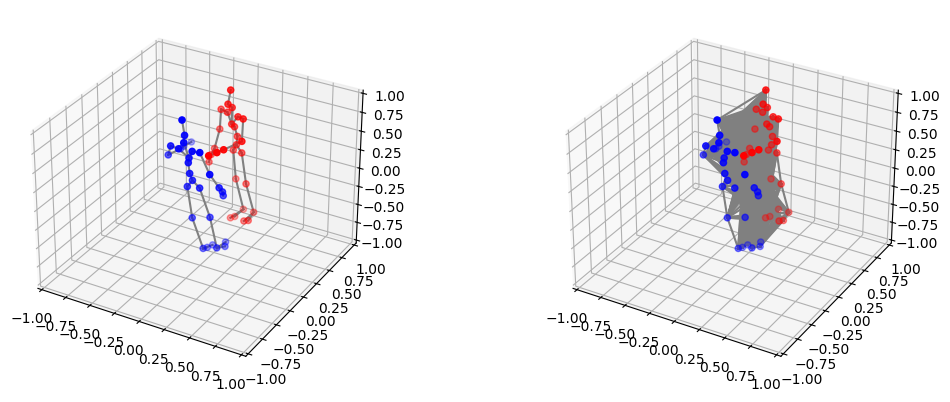

In [3]:
# Visualizing joint skeletons for random frame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure(figsize=(12, 4))

# Plotting dancers
ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

rand_frame = 42
ax1.scatter(joint_poses[rand_frame, :n_joints, 2], joint_poses[rand_frame, :n_joints, 0], \
            -joint_poses[rand_frame, :n_joints, 1], color='red')
ax1.scatter(joint_poses[rand_frame, n_joints:, 2], joint_poses[rand_frame, n_joints:, 0], \
            -joint_poses[rand_frame, n_joints:, 1], color='blue')

for (start, end) in skeletons:
    xs = [joint_poses[rand_frame, start, 2], joint_poses[rand_frame, end, 2]]
    ys = [joint_poses[rand_frame, start, 0], joint_poses[rand_frame, end, 0]]
    zs = [-joint_poses[rand_frame, start, 1], -joint_poses[rand_frame, end, 1]]
    ax1.plot(xs, ys, zs, color='grey')

# Plotting dancers with fully connected joints
ax2 = fig.add_subplot(122, projection="3d")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

rand_frame = 42
ax2.scatter(joint_poses[rand_frame, :n_joints, 2], joint_poses[rand_frame, :n_joints, 0], \
            -joint_poses[rand_frame, :n_joints, 1], color='red')
ax2.scatter(joint_poses[rand_frame, n_joints:, 2], joint_poses[rand_frame, n_joints:, 0], \
            -joint_poses[rand_frame, n_joints:, 1], color='blue')

for (start, end) in edge_index_t:
    xs = [joint_poses[rand_frame, start, 2], joint_poses[rand_frame, end, 2]]
    ys = [joint_poses[rand_frame, start, 0], joint_poses[rand_frame, end, 0]]
    zs = [-joint_poses[rand_frame, start, 1], -joint_poses[rand_frame, end, 1]]
    ax2.plot(xs, ys, zs, color='grey')

plt.tight_layout()
plt.show()

In [4]:
import torch

# Building sequences
joint_poses = torch.Tensor(joint_poses)

seq_len = 32
num_seqs = joint_poses.shape[0] // seq_len
batches = torch.stack([joint_poses[i*seq_len:(i+1)*seq_len] for i in range(num_seqs)])

# Training-validation split
train_val_split = int(0.85*num_seqs)
train_batches = batches[:train_val_split]
val_batches = batches[train_val_split:]

print('Shape of training data with sequences: {}'.format(train_batches.shape))
print('Shape of validation data with sequences: {}'.format(val_batches.shape))

Shape of training data with sequences: torch.Size([568, 32, 58, 3])
Shape of validation data with sequences: torch.Size([101, 32, 58, 3])


# Bulding Models

<p style="font-size:16px;">The developed models were:</p>
<ul style="font-size:16px;">
    <li><b>NRI Variant:</b> Building a GCN variation of the Neural Relational Inference (NRI) model for the task of graph structure learning given sequences of movement (interactions of joints)</li>
    <li>Temporal model (?)</li>
</ul>

## NRI Variant

<p style="font-size:16px;">
    This model is a variant of the Neural Relational Inference (NRI) model, which itself is an extension of the traditional Variational Autoencoder (VAE). The primary objective of the original model is to study particles that move together in a system without prior knowledge of their underlying relationships. By analyzing their movements, the model aims to estimate a graph structure that connects these particles. In our context, the particles are represented by the joints of dancers. Although we know the physical connections between joints within a dancer's body, this information is insufficient to understand the artistic relationships between two dancers, such as how their joints move together or in opposition.
</p>

<p style="font-size:16px;">
Since we lack a target graph structure that correctly identifies which joints are virtually connected during a dance performance, and given that this graph can change over time within a performance (focusing on different body parts at different times), we employ self-supervising techniques.
</p>

<b style="font-size:18px;">Model Overview</b>

<p style="font-size:16px;">
The model consists of an encoder and a decoder, which play around with transforming node representations into edge representations and vice versa. This approach focuses on the dynamics of movements rather than fixed node embeddings. Since the encoder outputs edges (specifically, samples edges from the generated latent space), it is crucial to switch between these representations.
</p>

<p style="font-size:16px;">
Our implementation is similar to the NRI MLP-Encoder MLP-Decoder model, but with a couple of modifications:
</p>

<ul style="font-size:16px;">
    <li><b>Graph Convolutional Network (GCN):</b> We replaced some MLP layers with GCN layers to leverage the graph structure, improving the model's ability to capture relationships between joints. This change also helps us focus on a subset of edges that connect both dancers, rather than studying all particle relationships as in the original implementation. Additionally GCNs provide local feature aggregation and parameter sharing, important inductive biases for our context and resulting in enhanced generalization in a scenario with a "dynamic" (unknown) graph structure</li>
    <li><b>Use of Modern Libraries:</b> We utilize PyTorch Geometric for its advanced features and ease of use</li>
</ul>

<p style="font-size:16px;">
By incorporating these modifications, our model maintains the core principles of the original NRI model while enhancing its ability to generalize and adapt to the dynamic nature of dance performances.
</p>

<b style="font-size:18px;">Final Architecture</b>

<ol style="font-size:16px;">
    <li>The model includes a GCN layer followed by a transformation of node representations into edge representations</li>
    <li>We then use an MLP layer, batch normalization and dropout</li>
    <li>After that, we convert edges back to nodes and apply another GCN layer</li>
    <li>Nodes are then transformed back into edges, followed by another MLP with a skip connection from the dropout layer</li>
    <li>And a final MLP layer outputs logits with two features representing the edge types (existing or non-existing)</li>
</ol>

</p>

<p style="font-size:16px;">The developed models are:</p>
<ul>
    <li>Reading preprocessed data in an interleaved manner to extract data from both dancers separately</li>
    <li>Creating adjacencies by:
        <ol>
            <li>Initializing default skeleton for 29 joints</li>
            <li>Repeating the process for the second dancer</li>
            <li>Connecting every joint of a dancer to all joints on the other dancer (these are the ones we want to classify as existing or non-existing with the NRI model)</li>
        </ol>
    </li>
    <li>Visualizing both dancers with their default skeletons and also with the connecting edges</li>
    <li>Preparing batches with PyTorch tensors of shape (batches, length_of_sequences, number_of_joints_from_both_dancers, dimensions)</li>
    <li>Creating training-validation split</li>
</ul>

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Creating message passing matrices for receivers and senders - shape R^(E x N)
def message_passing_matrices(n_joints, edge_index):
    message_passing_in = torch.zeros((edge_index.size(1), n_joints))
    message_passing_out = torch.zeros((edge_index.size(1), n_joints))

    for j in range(edge_index.size(1)):
        message_passing_out[j, int(edge_index[0, j])] = 1.
        message_passing_in[j, int(edge_index[1, j])] = 1.

    return message_passing_in, message_passing_out

# NRI VAE auxiliar functions to change between nodes and edges
def node2edge(x, m_in, m_out):    
    receivers = torch.matmul(m_in, x)
    senders = torch.matmul(m_out, x)
    edges = torch.cat([senders, receivers], dim=1)
    
    return edges


def edge2node(x, m_in):
    incoming = torch.matmul(m_in.t(), x)
    
    return incoming / incoming.size(0)


# Gumbel-Softmax sampling function to allow for backpropagation with categorical distributions
def gumbel_softmax_sample(logits, temp, hard=False):
    y = F.gumbel_softmax(logits, tau=temp, hard=hard)
    
    return y


# Computing KL Divergence for categorical distribution
def gumbel_softmax_kl_divergence(logits, log_prior, batch_size):
    q_y = F.softmax(logits, dim=-1)
    kl_div = q_y * (F.log_softmax(logits, dim=-1) - log_prior)
    
    return kl_div.sum() / batch_size


# Initializing reconstruction losses
nll_gaussian = nn.GaussianNLLLoss(reduction='mean') # Gaussian NLL
mse = nn.MSELoss(reduction='mean') # MSE

In [6]:
# Defining NRI encoder
import torch_geometric.nn as geo_nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d, Dropout

class nri_encoder(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, n_out, do_prob=0.):
        super(nri_encoder, self).__init__()

        # Computing edge index given transposed edge index
        self.edge_index = torch.Tensor(edge_index_t).t().long().to(device)

        # Computing the message passing matrices
        self.m_in, self.m_out = message_passing_matrices(n_joints, self.edge_index)
        self.m_in = self.m_in.to(device)
        self.m_out = self.m_out.to(device)

        # Defining the network itself interleaving GCN and MLP layers
        self.conv1 = GCNConv(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.bnorm1 = BatchNorm1d(n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv2 = GCNConv(n_hid, n_hid).to(device)
        
        self.mlp2 = Linear(n_hid*3, n_hid).to(device)
        self.bnorm2 = BatchNorm1d(n_hid).to(device)
        
        self.fc_out = Linear(n_hid, n_out).to(device)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x):
        # Rearranging shapes: [num_seqs, num_timesteps, num_atoms, num_dims] -> [num_seqs, num_atoms, num_timesteps*num_dims]
        x = x.view(x.size(0), x.size(2), -1)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = self.conv1(x, self.edge_index)
        x = F.relu(x)

        edge_x = [node2edge(x_samp, self.m_in, self.m_out) for x_samp in x]
        x = torch.stack(edge_x)
        
        x = self.mlp1(x)
        x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.bnorm1(x)
        x = x.permute(0, 2, 1)
        
        x = self.dropout1(x)

        # Skip connection
        x_skip = x.clone()

        node_x = [edge2node(x_samp, self.m_in) for x_samp in x]
        x = torch.stack(node_x)
        
        x = self.conv2(x, self.edge_index)
        x = F.relu(x)
        
        edge_x = [node2edge(x_samp, self.m_in, self.m_out) for x_samp in x]
        x = torch.stack(edge_x)
        
        x = torch.cat((x, x_skip), dim=2)
        x = self.mlp2(x)
        x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.bnorm2(x)
        x = x.permute(0, 2, 1)

        return self.fc_out(x)

In [7]:
# Defining NRI decoder
class nri_decoder(nn.Module):
    def __init__(self, device, n_in, n_hid, n_out, do_prob=0.):
        super(nri_decoder, self).__init__()

        # Defining the network itself interleaving GCN and MLP layers
        self.conv1 = GCNConv(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.bnorm1 = BatchNorm1d(n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv2 = GCNConv(n_hid, n_out).to(device)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x, edge_index, m_in, m_out):
        # Rearranging shapes: [num_seqs, num_timesteps, num_atoms, num_dims] -> [num_seqs, num_atoms, num_timesteps*num_dims]
        x = x.view(x.size(0), x.size(2), -1)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        edge_x = [node2edge(x_samp, m_in, m_out) for x_samp in x]
        x = torch.stack(edge_x)
        
        x = self.mlp1(x)
        x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.bnorm1(x)
        x = x.permute(0, 2, 1)
        
        x = self.dropout1(x)

        node_x = [edge2node(x_samp, m_in) for x_samp in x]
        x = torch.stack(node_x)
        
        x = self.conv2(x, edge_index)

        return x

In [8]:
# Defining NRI VAE
class nri_vae(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, edge_types, tau, hard, do_prob=0.):
        super(nri_vae, self).__init__()

        # Initializing encoder and decoder
        self.encoder = nri_encoder(device, n_joints, edge_index_t, n_in, n_hid, edge_types, do_prob)
        self.decoder = nri_decoder(device, n_in, n_hid, n_in, do_prob)

        # Saving variables that will be used by the forward pass
        self.device = device
        self.n_joints = n_joints
        
        self.tau = tau
        self.hard = hard
    
    def forward(self, x):
        # Computing logits for edges with encoder
        logits = self.encoder(x)

        # Sampling edge index classes using Gumbel-Softmax. Since we are using only two types of edges at the moment,
        # existent or non-existent, we create a newly sampled edge index for the decoder to use
        edge_index_classes = gumbel_softmax_sample(logits, tau, hard)
        edge_index_samp = torch.Tensor(edge_index_t).to(x.device)[torch.where(edge_index_classes[:, 1])[0]].t().long()

        # Creating message passing matrices for decoder newly sampled edge index
        decoder_m_in, decoder_m_out = message_passing_matrices(self.n_joints, edge_index_samp)
        decoder_m_in = decoder_m_in.to(self.device)
        decoder_m_out = decoder_m_out.to(self.device)

        # Reconstructing sequences using decoder
        recon_output = self.decoder(x, edge_index_samp, decoder_m_in, decoder_m_out)

        return logits, recon_output

In [9]:
import time
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

# Initializing all the hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8
train_num_batches = (train_batches.size(0) // batch_size) - 1
val_num_batches = (val_batches.size(0) // batch_size) - 1

seq_len = batches.size(1)
n_joints = batches.size(2)
dims = batches.size(3)

hidden_dims = 256
edge_types = 2

tau = 0.5
hard = True
dropout = 0.1
factor = True
out_var = 5e-5

prior = [0.9, 0.1]
log_prior = torch.FloatTensor(np.log(prior)).unsqueeze(0).unsqueeze(0)

epochs = 500
lr = 5e-4
lr_decay = 200
gamma = 0.5

# Initializing model, optimizer and scheduler
model = nri_vae(device, n_joints, edge_index_t, seq_len*dims, hidden_dims, edge_types, tau, hard, dropout)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay, gamma=gamma)

# Initializing lists to save losses across iterations
kl_train = []
recon_train = []
loss_train = []
kl_val = []
recon_val = []
loss_val = []

# Initializing variables to save best model
best_val_loss = torch.inf
best_epoch = 0

# Training loop
for epoch in tqdm(range(epochs), desc='Training Epochs'):
    t = time.time()

    kl_aux = []
    recon_aux = []
    loss_aux = []

    # Training data
    model.train()
    for idx in range(train_num_batches):
        optimizer.zero_grad()
        
        batch = train_batches[idx*batch_size:(idx+1)*batch_size]
        batch = batch.to(device)
        logits, recon_output = model(batch)

        kl_loss = gumbel_softmax_kl_divergence(logits, log_prior.to(device), batch_size)
        
        recon_output = recon_output.view(batch_size, seq_len, n_joints, dims)
        # nll_loss = nll_gaussian(recon_output, train_batches[(idx+1)*batch_size:(idx+2)*batch_size].to(device), \
        #                         torch.full(recon_output.shape, out_var, device=device))
        mse_loss = mse(recon_output, train_batches[(idx+1)*batch_size:(idx+2)*batch_size].to(device))

        # loss = kl_loss + nll_loss
        loss = 0.001*kl_loss + mse_loss
        loss.backward()
        optimizer.step()

        kl_aux.append(0.001*kl_loss)
        # recon_aux.append(nll_loss)
        recon_aux.append(mse_loss)
        loss_aux.append(loss.data.item())

    kl_aux = torch.Tensor(kl_aux)
    recon_aux = torch.Tensor(recon_aux)
    loss_aux = torch.Tensor(loss_aux)
    tqdm.write(f'Epoch: {epoch + 1:04d}, '
               f'KL Loss (Training): {torch.mean(kl_aux):.4f}, '
               f'Reconstruction Loss (Training): {torch.mean(recon_aux):.4f}, '
               f'Combined Loss (Training): {torch.mean(loss_aux):.4f}, '
               f'time: {time.time() - t:.4f}s')

    scheduler.step()

    kl_train.append(torch.mean(kl_aux))
    recon_train.append(torch.mean(recon_aux))
    loss_train.append(torch.mean(loss_aux))

    kl_aux = []
    recon_aux = []
    loss_aux = []

    # Validation data
    model.eval()
    for idx in range(val_num_batches):
        batch = val_batches[idx*batch_size:(idx+1)*batch_size]
        batch = batch.to(device)
        logits, recon_output = model(batch)

        kl_loss = gumbel_softmax_kl_divergence(logits, log_prior.to(device), batch_size)
        
        recon_output = recon_output.view(batch_size, seq_len, n_joints, dims)
        # nll_loss = nll_gaussian(recon_output, val_batches[(idx+1)*batch_size:(idx+2)*batch_size].to(device), \
        #                         torch.full(recon_output.shape, out_var, device=device))
        mse_loss = mse(recon_output, val_batches[(idx+1)*batch_size:(idx+2)*batch_size].to(device))

        # loss = kl_loss + nll_loss
        loss = 0.001*kl_loss + mse_loss
        
        kl_aux.append(0.001*kl_loss)
        # recon_aux.append(nll_loss)
        recon_aux.append(mse_loss)
        loss_aux.append(loss.data.item())

    kl_aux = torch.Tensor(kl_aux)
    recon_aux = torch.Tensor(recon_aux)
    loss_aux = torch.Tensor(loss_aux)
    tqdm.write(f'KL Loss (Validation): {torch.mean(kl_aux):.4f}, '
               f'Reconstruction Loss (Validation): {torch.mean(recon_aux):.4f}, '
               f'Combined Loss (Validation): {torch.mean(loss_aux):.4f}, '
               f'time: {time.time() - t:.4f}s')

    kl_val.append(torch.mean(kl_aux))
    recon_val.append(torch.mean(recon_aux))
    loss_val.append(torch.mean(loss_aux))

    if best_val_loss is torch.inf or loss_val < best_val_loss:
        best_val_loss = loss_val
        best_epoch = epoch

print("Optimization Finished!")

Training Epochs:   0%|                          | 1/500 [00:01<08:44,  1.05s/it]

Epoch: 0001, KL Loss (Training): 0.4047, Reconstruction Loss (Training): 0.2030, Combined Loss (Training): 0.6076, time: 0.9977s
KL Loss (Validation): 0.3799, Reconstruction Loss (Validation): 0.1712, Combined Loss (Validation): 0.5510, time: 1.0489s


Training Epochs:   0%|                          | 2/500 [00:01<06:29,  1.28it/s]

Epoch: 0002, KL Loss (Training): 0.1307, Reconstruction Loss (Training): 0.1991, Combined Loss (Training): 0.3298, time: 0.5438s
KL Loss (Validation): 0.1533, Reconstruction Loss (Validation): 0.1704, Combined Loss (Validation): 0.3237, time: 0.5915s


Training Epochs:   1%|▏                         | 3/500 [00:02<05:40,  1.46it/s]

Epoch: 0003, KL Loss (Training): 0.0861, Reconstruction Loss (Training): 0.1961, Combined Loss (Training): 0.2822, time: 0.5204s
KL Loss (Validation): 0.1327, Reconstruction Loss (Validation): 0.1701, Combined Loss (Validation): 0.3028, time: 0.5692s


Training Epochs:   1%|▏                         | 4/500 [00:02<05:15,  1.57it/s]

Epoch: 0004, KL Loss (Training): 0.0786, Reconstruction Loss (Training): 0.1937, Combined Loss (Training): 0.2723, time: 0.5126s
KL Loss (Validation): 0.1336, Reconstruction Loss (Validation): 0.1702, Combined Loss (Validation): 0.3038, time: 0.5591s


Training Epochs:   1%|▎                         | 5/500 [00:03<05:01,  1.64it/s]

Epoch: 0005, KL Loss (Training): 0.0741, Reconstruction Loss (Training): 0.1916, Combined Loss (Training): 0.2657, time: 0.5096s
KL Loss (Validation): 0.1292, Reconstruction Loss (Validation): 0.1707, Combined Loss (Validation): 0.2999, time: 0.5569s


Training Epochs:   1%|▎                         | 6/500 [00:03<04:52,  1.69it/s]

Epoch: 0006, KL Loss (Training): 0.0728, Reconstruction Loss (Training): 0.1898, Combined Loss (Training): 0.2626, time: 0.5131s
KL Loss (Validation): 0.0949, Reconstruction Loss (Validation): 0.1713, Combined Loss (Validation): 0.2662, time: 0.5600s


Training Epochs:   1%|▎                         | 7/500 [00:04<04:47,  1.72it/s]

Epoch: 0007, KL Loss (Training): 0.0694, Reconstruction Loss (Training): 0.1884, Combined Loss (Training): 0.2578, time: 0.5131s
KL Loss (Validation): 0.3783, Reconstruction Loss (Validation): 0.1723, Combined Loss (Validation): 0.5506, time: 0.5597s


Training Epochs:   2%|▍                         | 8/500 [00:05<04:43,  1.74it/s]

Epoch: 0008, KL Loss (Training): 0.0688, Reconstruction Loss (Training): 0.1872, Combined Loss (Training): 0.2560, time: 0.5119s
KL Loss (Validation): 0.0968, Reconstruction Loss (Validation): 0.1735, Combined Loss (Validation): 0.2703, time: 0.5590s


Training Epochs:   2%|▍                         | 9/500 [00:05<04:40,  1.75it/s]

Epoch: 0009, KL Loss (Training): 0.0683, Reconstruction Loss (Training): 0.1862, Combined Loss (Training): 0.2545, time: 0.5121s
KL Loss (Validation): 0.3469, Reconstruction Loss (Validation): 0.1746, Combined Loss (Validation): 0.5215, time: 0.5596s


Training Epochs:   2%|▌                        | 10/500 [00:06<04:39,  1.75it/s]

Epoch: 0010, KL Loss (Training): 0.0677, Reconstruction Loss (Training): 0.1854, Combined Loss (Training): 0.2530, time: 0.5183s
KL Loss (Validation): 0.0889, Reconstruction Loss (Validation): 0.1760, Combined Loss (Validation): 0.2649, time: 0.5653s


Training Epochs:   2%|▌                        | 11/500 [00:06<04:37,  1.76it/s]

Epoch: 0011, KL Loss (Training): 0.0612, Reconstruction Loss (Training): 0.1846, Combined Loss (Training): 0.2458, time: 0.5147s
KL Loss (Validation): 0.1753, Reconstruction Loss (Validation): 0.1773, Combined Loss (Validation): 0.3526, time: 0.5628s


Training Epochs:   2%|▌                        | 12/500 [00:07<04:37,  1.76it/s]

Epoch: 0012, KL Loss (Training): 0.0427, Reconstruction Loss (Training): 0.1840, Combined Loss (Training): 0.2267, time: 0.5159s
KL Loss (Validation): 0.0441, Reconstruction Loss (Validation): 0.1790, Combined Loss (Validation): 0.2231, time: 0.5639s


Training Epochs:   3%|▋                        | 13/500 [00:07<04:36,  1.76it/s]

Epoch: 0013, KL Loss (Training): 0.0263, Reconstruction Loss (Training): 0.1835, Combined Loss (Training): 0.2098, time: 0.5155s
KL Loss (Validation): 0.0427, Reconstruction Loss (Validation): 0.1808, Combined Loss (Validation): 0.2235, time: 0.5631s


Training Epochs:   3%|▋                        | 14/500 [00:08<04:35,  1.76it/s]

Epoch: 0014, KL Loss (Training): 0.0173, Reconstruction Loss (Training): 0.1830, Combined Loss (Training): 0.2003, time: 0.5178s
KL Loss (Validation): 0.0412, Reconstruction Loss (Validation): 0.1821, Combined Loss (Validation): 0.2232, time: 0.5668s


Training Epochs:   3%|▊                        | 15/500 [00:08<04:35,  1.76it/s]

Epoch: 0015, KL Loss (Training): 0.0111, Reconstruction Loss (Training): 0.1826, Combined Loss (Training): 0.1937, time: 0.5192s
KL Loss (Validation): 0.0559, Reconstruction Loss (Validation): 0.1841, Combined Loss (Validation): 0.2401, time: 0.5670s


Training Epochs:   3%|▊                        | 16/500 [00:09<04:36,  1.75it/s]

Epoch: 0016, KL Loss (Training): 0.0090, Reconstruction Loss (Training): 0.1822, Combined Loss (Training): 0.1912, time: 0.5264s
KL Loss (Validation): 0.0322, Reconstruction Loss (Validation): 0.1848, Combined Loss (Validation): 0.2170, time: 0.5735s


Training Epochs:   3%|▊                        | 17/500 [00:10<04:36,  1.75it/s]

Epoch: 0017, KL Loss (Training): 0.0062, Reconstruction Loss (Training): 0.1818, Combined Loss (Training): 0.1880, time: 0.5284s
KL Loss (Validation): 0.0334, Reconstruction Loss (Validation): 0.1857, Combined Loss (Validation): 0.2191, time: 0.5756s


Training Epochs:   4%|▉                        | 18/500 [00:10<04:36,  1.74it/s]

Epoch: 0018, KL Loss (Training): 0.0050, Reconstruction Loss (Training): 0.1815, Combined Loss (Training): 0.1865, time: 0.5251s
KL Loss (Validation): 0.0286, Reconstruction Loss (Validation): 0.1871, Combined Loss (Validation): 0.2157, time: 0.5731s


Training Epochs:   4%|▉                        | 19/500 [00:11<04:37,  1.73it/s]

Epoch: 0019, KL Loss (Training): 0.0042, Reconstruction Loss (Training): 0.1812, Combined Loss (Training): 0.1854, time: 0.5336s
KL Loss (Validation): 0.0500, Reconstruction Loss (Validation): 0.1882, Combined Loss (Validation): 0.2381, time: 0.5836s


Training Epochs:   4%|█                        | 20/500 [00:11<04:35,  1.74it/s]

Epoch: 0020, KL Loss (Training): 0.0034, Reconstruction Loss (Training): 0.1809, Combined Loss (Training): 0.1843, time: 0.5168s
KL Loss (Validation): 0.0868, Reconstruction Loss (Validation): 0.1899, Combined Loss (Validation): 0.2768, time: 0.5651s


Training Epochs:   4%|█                        | 21/500 [00:12<04:34,  1.75it/s]

Epoch: 0021, KL Loss (Training): 0.0035, Reconstruction Loss (Training): 0.1807, Combined Loss (Training): 0.1842, time: 0.5206s
KL Loss (Validation): 0.0736, Reconstruction Loss (Validation): 0.1899, Combined Loss (Validation): 0.2634, time: 0.5671s


Training Epochs:   4%|█                        | 22/500 [00:13<04:35,  1.74it/s]

Epoch: 0022, KL Loss (Training): 0.0029, Reconstruction Loss (Training): 0.1804, Combined Loss (Training): 0.1833, time: 0.5343s
KL Loss (Validation): 0.1055, Reconstruction Loss (Validation): 0.1905, Combined Loss (Validation): 0.2960, time: 0.5810s


Training Epochs:   5%|█▏                       | 23/500 [00:13<04:32,  1.75it/s]

Epoch: 0023, KL Loss (Training): 0.0033, Reconstruction Loss (Training): 0.1802, Combined Loss (Training): 0.1834, time: 0.5131s
KL Loss (Validation): 0.0768, Reconstruction Loss (Validation): 0.1924, Combined Loss (Validation): 0.2692, time: 0.5593s


Training Epochs:   5%|█▏                       | 24/500 [00:14<04:31,  1.76it/s]

Epoch: 0024, KL Loss (Training): 0.0028, Reconstruction Loss (Training): 0.1799, Combined Loss (Training): 0.1827, time: 0.5151s
KL Loss (Validation): 0.0946, Reconstruction Loss (Validation): 0.1932, Combined Loss (Validation): 0.2877, time: 0.5628s


Training Epochs:   5%|█▎                       | 25/500 [00:14<04:30,  1.76it/s]

Epoch: 0025, KL Loss (Training): 0.0025, Reconstruction Loss (Training): 0.1797, Combined Loss (Training): 0.1822, time: 0.5192s
KL Loss (Validation): 0.0933, Reconstruction Loss (Validation): 0.1921, Combined Loss (Validation): 0.2854, time: 0.5679s


Training Epochs:   5%|█▎                       | 26/500 [00:15<04:32,  1.74it/s]

Epoch: 0026, KL Loss (Training): 0.0021, Reconstruction Loss (Training): 0.1795, Combined Loss (Training): 0.1816, time: 0.5361s
KL Loss (Validation): 0.0931, Reconstruction Loss (Validation): 0.1940, Combined Loss (Validation): 0.2871, time: 0.5822s


Training Epochs:   5%|█▎                       | 27/500 [00:15<04:31,  1.74it/s]

Epoch: 0027, KL Loss (Training): 0.0016, Reconstruction Loss (Training): 0.1794, Combined Loss (Training): 0.1810, time: 0.5210s
KL Loss (Validation): 0.0607, Reconstruction Loss (Validation): 0.1942, Combined Loss (Validation): 0.2550, time: 0.5688s


Training Epochs:   6%|█▍                       | 28/500 [00:16<04:29,  1.75it/s]

Epoch: 0028, KL Loss (Training): 0.0015, Reconstruction Loss (Training): 0.1792, Combined Loss (Training): 0.1807, time: 0.5138s
KL Loss (Validation): 0.0951, Reconstruction Loss (Validation): 0.1929, Combined Loss (Validation): 0.2880, time: 0.5622s


Training Epochs:   6%|█▍                       | 29/500 [00:16<04:27,  1.76it/s]

Epoch: 0029, KL Loss (Training): 0.0011, Reconstruction Loss (Training): 0.1791, Combined Loss (Training): 0.1802, time: 0.5122s
KL Loss (Validation): 0.1070, Reconstruction Loss (Validation): 0.1960, Combined Loss (Validation): 0.3030, time: 0.5594s


Training Epochs:   6%|█▌                       | 30/500 [00:17<04:26,  1.76it/s]

Epoch: 0030, KL Loss (Training): 0.0010, Reconstruction Loss (Training): 0.1789, Combined Loss (Training): 0.1799, time: 0.5188s
KL Loss (Validation): 0.1020, Reconstruction Loss (Validation): 0.1948, Combined Loss (Validation): 0.2967, time: 0.5658s


Training Epochs:   6%|█▌                       | 31/500 [00:18<04:28,  1.74it/s]

Epoch: 0031, KL Loss (Training): 0.0008, Reconstruction Loss (Training): 0.1787, Combined Loss (Training): 0.1796, time: 0.5380s
KL Loss (Validation): 0.0974, Reconstruction Loss (Validation): 0.1890, Combined Loss (Validation): 0.2864, time: 0.5837s


Training Epochs:   6%|█▌                       | 32/500 [00:18<04:31,  1.72it/s]

Epoch: 0032, KL Loss (Training): 0.0008, Reconstruction Loss (Training): 0.1786, Combined Loss (Training): 0.1795, time: 0.5461s
KL Loss (Validation): 0.0989, Reconstruction Loss (Validation): 0.1996, Combined Loss (Validation): 0.2985, time: 0.5930s


Training Epochs:   7%|█▋                       | 33/500 [00:19<04:30,  1.73it/s]

Epoch: 0033, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1786, Combined Loss (Training): 0.1793, time: 0.5292s
KL Loss (Validation): 0.0986, Reconstruction Loss (Validation): 0.1903, Combined Loss (Validation): 0.2889, time: 0.5766s


Training Epochs:   7%|█▋                       | 34/500 [00:19<04:30,  1.73it/s]

Epoch: 0034, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1785, Combined Loss (Training): 0.1792, time: 0.5292s
KL Loss (Validation): 0.0975, Reconstruction Loss (Validation): 0.1924, Combined Loss (Validation): 0.2899, time: 0.5780s


Training Epochs:   7%|█▊                       | 35/500 [00:20<04:29,  1.73it/s]

Epoch: 0035, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1783, Combined Loss (Training): 0.1789, time: 0.5282s
KL Loss (Validation): 0.0986, Reconstruction Loss (Validation): 0.1976, Combined Loss (Validation): 0.2962, time: 0.5764s


Training Epochs:   7%|█▊                       | 36/500 [00:21<04:28,  1.72it/s]

Epoch: 0036, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1781, Combined Loss (Training): 0.1788, time: 0.5306s
KL Loss (Validation): 0.0980, Reconstruction Loss (Validation): 0.1920, Combined Loss (Validation): 0.2901, time: 0.5781s


Training Epochs:   7%|█▊                       | 37/500 [00:21<04:29,  1.72it/s]

Epoch: 0037, KL Loss (Training): 0.0006, Reconstruction Loss (Training): 0.1780, Combined Loss (Training): 0.1786, time: 0.5399s
KL Loss (Validation): 0.1016, Reconstruction Loss (Validation): 0.1994, Combined Loss (Validation): 0.3010, time: 0.5862s


Training Epochs:   8%|█▉                       | 38/500 [00:22<04:28,  1.72it/s]

Epoch: 0038, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1779, Combined Loss (Training): 0.1786, time: 0.5294s
KL Loss (Validation): 0.1011, Reconstruction Loss (Validation): 0.1924, Combined Loss (Validation): 0.2935, time: 0.5761s


Training Epochs:   8%|█▉                       | 39/500 [00:22<04:28,  1.72it/s]

Epoch: 0039, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1778, Combined Loss (Training): 0.1786, time: 0.5346s
KL Loss (Validation): 0.1026, Reconstruction Loss (Validation): 0.2010, Combined Loss (Validation): 0.3036, time: 0.5812s


Training Epochs:   8%|██                       | 40/500 [00:23<04:26,  1.73it/s]

Epoch: 0040, KL Loss (Training): 0.0008, Reconstruction Loss (Training): 0.1779, Combined Loss (Training): 0.1786, time: 0.5244s
KL Loss (Validation): 0.1030, Reconstruction Loss (Validation): 0.1897, Combined Loss (Validation): 0.2927, time: 0.5696s


Training Epochs:   8%|██                       | 41/500 [00:23<04:26,  1.72it/s]

Epoch: 0041, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1779, Combined Loss (Training): 0.1786, time: 0.5335s
KL Loss (Validation): 0.1096, Reconstruction Loss (Validation): 0.1947, Combined Loss (Validation): 0.3043, time: 0.5816s


Training Epochs:   8%|██                       | 42/500 [00:24<04:26,  1.72it/s]

Epoch: 0042, KL Loss (Training): 0.0008, Reconstruction Loss (Training): 0.1777, Combined Loss (Training): 0.1785, time: 0.5373s
KL Loss (Validation): 0.1137, Reconstruction Loss (Validation): 0.1916, Combined Loss (Validation): 0.3052, time: 0.5831s


Training Epochs:   9%|██▏                      | 43/500 [00:25<04:22,  1.74it/s]

Epoch: 0043, KL Loss (Training): 0.0010, Reconstruction Loss (Training): 0.1775, Combined Loss (Training): 0.1785, time: 0.5151s
KL Loss (Validation): 0.1138, Reconstruction Loss (Validation): 0.1970, Combined Loss (Validation): 0.3108, time: 0.5576s


Training Epochs:   9%|██▏                      | 44/500 [00:25<04:19,  1.76it/s]

Epoch: 0044, KL Loss (Training): 0.0009, Reconstruction Loss (Training): 0.1774, Combined Loss (Training): 0.1783, time: 0.5048s
KL Loss (Validation): 0.1177, Reconstruction Loss (Validation): 0.1913, Combined Loss (Validation): 0.3090, time: 0.5526s


Training Epochs:   9%|██▎                      | 45/500 [00:26<04:20,  1.74it/s]

Epoch: 0045, KL Loss (Training): 0.0010, Reconstruction Loss (Training): 0.1773, Combined Loss (Training): 0.1783, time: 0.5320s
KL Loss (Validation): 0.1190, Reconstruction Loss (Validation): 0.1968, Combined Loss (Validation): 0.3157, time: 0.5812s


Training Epochs:   9%|██▎                      | 46/500 [00:26<04:18,  1.75it/s]

Epoch: 0046, KL Loss (Training): 0.0010, Reconstruction Loss (Training): 0.1773, Combined Loss (Training): 0.1783, time: 0.5175s
KL Loss (Validation): 0.1282, Reconstruction Loss (Validation): 0.1899, Combined Loss (Validation): 0.3181, time: 0.5615s


Training Epochs:   9%|██▎                      | 47/500 [00:27<04:16,  1.76it/s]

Epoch: 0047, KL Loss (Training): 0.0010, Reconstruction Loss (Training): 0.1772, Combined Loss (Training): 0.1782, time: 0.5125s
KL Loss (Validation): 0.1557, Reconstruction Loss (Validation): 0.1959, Combined Loss (Validation): 0.3516, time: 0.5566s


Training Epochs:  10%|██▍                      | 48/500 [00:27<04:20,  1.74it/s]

Epoch: 0048, KL Loss (Training): 0.0010, Reconstruction Loss (Training): 0.1772, Combined Loss (Training): 0.1782, time: 0.5469s
KL Loss (Validation): 0.1841, Reconstruction Loss (Validation): 0.1898, Combined Loss (Validation): 0.3739, time: 0.5933s


Training Epochs:  10%|██▍                      | 49/500 [00:28<04:17,  1.75it/s]

Epoch: 0049, KL Loss (Training): 0.0012, Reconstruction Loss (Training): 0.1772, Combined Loss (Training): 0.1784, time: 0.5152s
KL Loss (Validation): 0.2070, Reconstruction Loss (Validation): 0.1991, Combined Loss (Validation): 0.4061, time: 0.5573s


Training Epochs:  10%|██▌                      | 50/500 [00:29<04:15,  1.76it/s]

Epoch: 0050, KL Loss (Training): 0.0012, Reconstruction Loss (Training): 0.1772, Combined Loss (Training): 0.1784, time: 0.5145s
KL Loss (Validation): 0.1929, Reconstruction Loss (Validation): 0.1926, Combined Loss (Validation): 0.3855, time: 0.5571s


Training Epochs:  10%|██▌                      | 51/500 [00:29<04:15,  1.76it/s]

Epoch: 0051, KL Loss (Training): 0.0009, Reconstruction Loss (Training): 0.1770, Combined Loss (Training): 0.1779, time: 0.5243s
KL Loss (Validation): 0.1883, Reconstruction Loss (Validation): 0.1973, Combined Loss (Validation): 0.3856, time: 0.5703s


Training Epochs:  10%|██▌                      | 52/500 [00:30<04:12,  1.77it/s]

Epoch: 0052, KL Loss (Training): 0.0007, Reconstruction Loss (Training): 0.1769, Combined Loss (Training): 0.1776, time: 0.5075s
KL Loss (Validation): 0.1328, Reconstruction Loss (Validation): 0.1920, Combined Loss (Validation): 0.3248, time: 0.5506s


Training Epochs:  11%|██▋                      | 53/500 [00:30<04:11,  1.78it/s]

Epoch: 0053, KL Loss (Training): 0.0006, Reconstruction Loss (Training): 0.1768, Combined Loss (Training): 0.1774, time: 0.5116s
KL Loss (Validation): 0.1331, Reconstruction Loss (Validation): 0.1943, Combined Loss (Validation): 0.3274, time: 0.5540s


Training Epochs:  11%|██▋                      | 54/500 [00:31<04:09,  1.79it/s]

Epoch: 0054, KL Loss (Training): 0.0004, Reconstruction Loss (Training): 0.1767, Combined Loss (Training): 0.1772, time: 0.5102s
KL Loss (Validation): 0.1153, Reconstruction Loss (Validation): 0.1896, Combined Loss (Validation): 0.3050, time: 0.5531s


Training Epochs:  11%|██▊                      | 55/500 [00:31<04:09,  1.79it/s]

Epoch: 0055, KL Loss (Training): 0.0004, Reconstruction Loss (Training): 0.1767, Combined Loss (Training): 0.1771, time: 0.5151s
KL Loss (Validation): 0.1184, Reconstruction Loss (Validation): 0.1937, Combined Loss (Validation): 0.3121, time: 0.5573s


Training Epochs:  11%|██▊                      | 56/500 [00:32<04:09,  1.78it/s]

Epoch: 0056, KL Loss (Training): 0.0004, Reconstruction Loss (Training): 0.1767, Combined Loss (Training): 0.1771, time: 0.5083s
KL Loss (Validation): 0.1771, Reconstruction Loss (Validation): 0.1927, Combined Loss (Validation): 0.3698, time: 0.5635s


Training Epochs:  11%|██▊                      | 57/500 [00:33<04:08,  1.78it/s]

Epoch: 0057, KL Loss (Training): 0.0003, Reconstruction Loss (Training): 0.1766, Combined Loss (Training): 0.1770, time: 0.5133s
KL Loss (Validation): 0.1381, Reconstruction Loss (Validation): 0.1949, Combined Loss (Validation): 0.3330, time: 0.5564s


Training Epochs:  12%|██▉                      | 58/500 [00:33<04:08,  1.78it/s]

Epoch: 0058, KL Loss (Training): 0.0004, Reconstruction Loss (Training): 0.1765, Combined Loss (Training): 0.1769, time: 0.5234s
KL Loss (Validation): 0.1369, Reconstruction Loss (Validation): 0.1909, Combined Loss (Validation): 0.3278, time: 0.5670s


Training Epochs:  12%|██▉                      | 59/500 [00:34<04:09,  1.77it/s]

Epoch: 0059, KL Loss (Training): 0.0003, Reconstruction Loss (Training): 0.1766, Combined Loss (Training): 0.1769, time: 0.5236s
KL Loss (Validation): 0.1330, Reconstruction Loss (Validation): 0.2013, Combined Loss (Validation): 0.3343, time: 0.5708s


Training Epochs:  12%|███                      | 60/500 [00:34<04:10,  1.75it/s]

Epoch: 0060, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1765, Combined Loss (Training): 0.1768, time: 0.5282s
KL Loss (Validation): 0.1259, Reconstruction Loss (Validation): 0.1903, Combined Loss (Validation): 0.3162, time: 0.5768s


Training Epochs:  12%|███                      | 61/500 [00:35<04:08,  1.76it/s]

Epoch: 0061, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1765, Combined Loss (Training): 0.1768, time: 0.5143s
KL Loss (Validation): 0.1260, Reconstruction Loss (Validation): 0.1938, Combined Loss (Validation): 0.3198, time: 0.5570s


Training Epochs:  12%|███                      | 62/500 [00:35<04:06,  1.77it/s]

Epoch: 0062, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1765, Combined Loss (Training): 0.1767, time: 0.5109s
KL Loss (Validation): 0.1264, Reconstruction Loss (Validation): 0.1886, Combined Loss (Validation): 0.3151, time: 0.5549s


Training Epochs:  13%|███▏                     | 63/500 [00:36<04:05,  1.78it/s]

Epoch: 0063, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1764, Combined Loss (Training): 0.1766, time: 0.5103s
KL Loss (Validation): 0.1359, Reconstruction Loss (Validation): 0.1956, Combined Loss (Validation): 0.3315, time: 0.5532s


Training Epochs:  13%|███▏                     | 64/500 [00:36<04:04,  1.79it/s]

Epoch: 0064, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1764, Combined Loss (Training): 0.1766, time: 0.5116s
KL Loss (Validation): 0.1227, Reconstruction Loss (Validation): 0.1885, Combined Loss (Validation): 0.3112, time: 0.5549s


Training Epochs:  13%|███▎                     | 65/500 [00:37<04:05,  1.77it/s]

Epoch: 0065, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1763, Combined Loss (Training): 0.1765, time: 0.5239s
KL Loss (Validation): 0.1305, Reconstruction Loss (Validation): 0.1939, Combined Loss (Validation): 0.3243, time: 0.5713s


Training Epochs:  13%|███▎                     | 66/500 [00:38<04:03,  1.78it/s]

Epoch: 0066, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1762, Combined Loss (Training): 0.1764, time: 0.5098s
KL Loss (Validation): 0.3845, Reconstruction Loss (Validation): 0.1894, Combined Loss (Validation): 0.5739, time: 0.5531s


Training Epochs:  13%|███▎                     | 67/500 [00:38<04:07,  1.75it/s]

Epoch: 0067, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1762, Combined Loss (Training): 0.1763, time: 0.5437s
KL Loss (Validation): 0.1330, Reconstruction Loss (Validation): 0.1924, Combined Loss (Validation): 0.3253, time: 0.5900s


Training Epochs:  14%|███▍                     | 68/500 [00:39<04:08,  1.74it/s]

Epoch: 0068, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1761, Combined Loss (Training): 0.1763, time: 0.5347s
KL Loss (Validation): 0.1262, Reconstruction Loss (Validation): 0.1889, Combined Loss (Validation): 0.3151, time: 0.5817s


Training Epochs:  14%|███▍                     | 69/500 [00:39<04:09,  1.73it/s]

Epoch: 0069, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1761, Combined Loss (Training): 0.1763, time: 0.5400s
KL Loss (Validation): 0.1250, Reconstruction Loss (Validation): 0.1945, Combined Loss (Validation): 0.3196, time: 0.5864s


Training Epochs:  14%|███▌                     | 70/500 [00:40<04:09,  1.72it/s]

Epoch: 0070, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1761, Combined Loss (Training): 0.1762, time: 0.5355s
KL Loss (Validation): 0.1229, Reconstruction Loss (Validation): 0.1898, Combined Loss (Validation): 0.3127, time: 0.5821s


Training Epochs:  14%|███▌                     | 71/500 [00:41<04:10,  1.71it/s]

Epoch: 0071, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1761, Combined Loss (Training): 0.1762, time: 0.5422s
KL Loss (Validation): 0.1203, Reconstruction Loss (Validation): 0.1881, Combined Loss (Validation): 0.3084, time: 0.5899s


Training Epochs:  14%|███▌                     | 72/500 [00:41<04:07,  1.73it/s]

Epoch: 0072, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1760, Combined Loss (Training): 0.1761, time: 0.5158s
KL Loss (Validation): 0.1188, Reconstruction Loss (Validation): 0.1886, Combined Loss (Validation): 0.3074, time: 0.5638s


Training Epochs:  15%|███▋                     | 73/500 [00:42<04:00,  1.77it/s]

Epoch: 0073, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1760, Combined Loss (Training): 0.1761, time: 0.4783s
KL Loss (Validation): 0.1275, Reconstruction Loss (Validation): 0.1911, Combined Loss (Validation): 0.3186, time: 0.5265s


Training Epochs:  15%|███▋                     | 74/500 [00:42<03:55,  1.81it/s]

Epoch: 0074, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1759, Combined Loss (Training): 0.1760, time: 0.4751s
KL Loss (Validation): 0.1222, Reconstruction Loss (Validation): 0.1881, Combined Loss (Validation): 0.3103, time: 0.5239s


Training Epochs:  15%|███▊                     | 75/500 [00:43<03:55,  1.80it/s]

Epoch: 0075, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1759, Combined Loss (Training): 0.1760, time: 0.5135s
KL Loss (Validation): 0.1211, Reconstruction Loss (Validation): 0.1904, Combined Loss (Validation): 0.3116, time: 0.5595s


Training Epochs:  15%|███▊                     | 76/500 [00:43<03:57,  1.78it/s]

Epoch: 0076, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1759, Combined Loss (Training): 0.1760, time: 0.5245s
KL Loss (Validation): 0.1223, Reconstruction Loss (Validation): 0.1887, Combined Loss (Validation): 0.3109, time: 0.5734s


Training Epochs:  15%|███▊                     | 77/500 [00:44<03:57,  1.78it/s]

Epoch: 0077, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1759, Combined Loss (Training): 0.1760, time: 0.5134s
KL Loss (Validation): 0.1201, Reconstruction Loss (Validation): 0.1901, Combined Loss (Validation): 0.3102, time: 0.5621s


Training Epochs:  16%|███▉                     | 78/500 [00:44<03:57,  1.78it/s]

Epoch: 0078, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1758, Combined Loss (Training): 0.1761, time: 0.5142s
KL Loss (Validation): 0.1204, Reconstruction Loss (Validation): 0.1892, Combined Loss (Validation): 0.3095, time: 0.5635s


Training Epochs:  16%|███▉                     | 79/500 [00:45<03:57,  1.78it/s]

Epoch: 0079, KL Loss (Training): 0.0003, Reconstruction Loss (Training): 0.1758, Combined Loss (Training): 0.1761, time: 0.5125s
KL Loss (Validation): 0.1169, Reconstruction Loss (Validation): 0.1894, Combined Loss (Validation): 0.3063, time: 0.5613s


Training Epochs:  16%|████                     | 80/500 [00:46<03:56,  1.78it/s]

Epoch: 0080, KL Loss (Training): 0.0003, Reconstruction Loss (Training): 0.1758, Combined Loss (Training): 0.1761, time: 0.5132s
KL Loss (Validation): 0.1170, Reconstruction Loss (Validation): 0.1881, Combined Loss (Validation): 0.3051, time: 0.5605s


Training Epochs:  16%|████                     | 81/500 [00:46<03:55,  1.78it/s]

Epoch: 0081, KL Loss (Training): 0.0003, Reconstruction Loss (Training): 0.1760, Combined Loss (Training): 0.1763, time: 0.5139s
KL Loss (Validation): 0.1154, Reconstruction Loss (Validation): 0.1892, Combined Loss (Validation): 0.3046, time: 0.5610s


Training Epochs:  16%|████                     | 82/500 [00:47<03:56,  1.77it/s]

Epoch: 0082, KL Loss (Training): 0.0002, Reconstruction Loss (Training): 0.1758, Combined Loss (Training): 0.1760, time: 0.5227s
KL Loss (Validation): 0.1137, Reconstruction Loss (Validation): 0.1902, Combined Loss (Validation): 0.3039, time: 0.5707s


Training Epochs:  17%|████▏                    | 83/500 [00:47<03:55,  1.77it/s]

Epoch: 0083, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1758, Combined Loss (Training): 0.1759, time: 0.5130s
KL Loss (Validation): 0.1130, Reconstruction Loss (Validation): 0.1879, Combined Loss (Validation): 0.3009, time: 0.5601s


Training Epochs:  17%|████▏                    | 84/500 [00:48<03:53,  1.78it/s]

Epoch: 0084, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1757, Combined Loss (Training): 0.1758, time: 0.5062s
KL Loss (Validation): 0.1129, Reconstruction Loss (Validation): 0.1878, Combined Loss (Validation): 0.3007, time: 0.5547s


Training Epochs:  17%|████▎                    | 85/500 [00:48<03:53,  1.78it/s]

Epoch: 0085, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1756, Combined Loss (Training): 0.1758, time: 0.5108s
KL Loss (Validation): 0.1120, Reconstruction Loss (Validation): 0.1881, Combined Loss (Validation): 0.3001, time: 0.5597s


Training Epochs:  17%|████▎                    | 86/500 [00:49<03:53,  1.78it/s]

Epoch: 0086, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1755, Combined Loss (Training): 0.1756, time: 0.5150s
KL Loss (Validation): 0.1122, Reconstruction Loss (Validation): 0.1877, Combined Loss (Validation): 0.2999, time: 0.5645s


Training Epochs:  17%|████▎                    | 87/500 [00:49<03:53,  1.77it/s]

Epoch: 0087, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1755, Combined Loss (Training): 0.1756, time: 0.5152s
KL Loss (Validation): 0.1131, Reconstruction Loss (Validation): 0.1881, Combined Loss (Validation): 0.3011, time: 0.5648s


Training Epochs:  18%|████▍                    | 88/500 [00:50<03:56,  1.74it/s]


Epoch: 0088, KL Loss (Training): 0.0001, Reconstruction Loss (Training): 0.1754, Combined Loss (Training): 0.1755, time: 0.4969s
KL Loss (Validation): 0.1136, Reconstruction Loss (Validation): 0.1885, Combined Loss (Validation): 0.3021, time: 0.5447s


KeyboardInterrupt: 